# CIFAR-10

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
transform = transforms.ToTensor()

In [19]:
train_data = datasets.CIFAR10(root="../Data", train=True, download=True,transform=transform)

100.0%


Extracting ../Data/cifar-10-python.tar.gz to ../Data


In [20]:
test_data = datasets.CIFAR10(root="../Data", train=False, download=True,transform=transform)

Files already downloaded and verified


In [48]:
torch.manual_seed(102)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [49]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [50]:
for images, labels in train_loader:
    break

In [51]:
labels

tensor([2, 9, 5, 5, 3, 7, 7, 6, 8, 8])

In [52]:
images.shape

torch.Size([10, 3, 32, 32])

Label: [2 9 5 5 3 7 7 6 8 8]
Class: [' bird' 'truck' '  dog' '  dog' '  cat' 'horse' 'horse' ' frog' ' ship'
 ' ship']


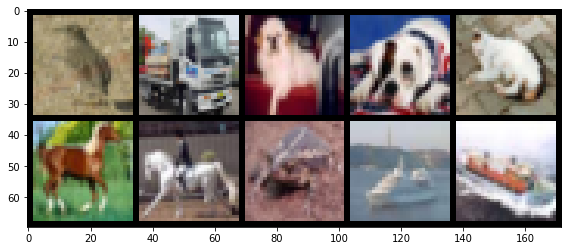

In [53]:
print("Label:", labels.numpy())
print("Class:", np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

## Creating the model

In [56]:
class Convolutionalnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1) # 3:input channel (3 colors),6: output Channels (filters) (arbitrary),5: Kernel. ,1: Stide
        self.conv2 = nn.Conv2d(6,16,3,1) # 16 and 3 is arbitrary and can be modified for better training performance
        self.fc1 = nn.Linear(6*6*16,120) # Se pytorch lect 68 ca 5 min hur denna räknas ut
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = self.conv1(X)
        X = F.relu(X)
        X = F.max_pool2d(X,2,2)
        X = self.conv2(X)
        X = F.relu(X)
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*16)
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)
        

In [58]:
torch.manual_seed(101)
model = Convolutionalnetwork()
model

Convolutionalnetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [59]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
import time
start_time = time.time()

# Variables (trackers)
epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0 

    # Train 
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train) # NOTE. No need to flatten as conv2d expect 2d data
        lossTrain = criterion(y_pred, y_train)
        #lossTrain = criterion(y_pred, y_train).data

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() # True 1 / False 0 
        trn_corr += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        if b%600 == 0:
            print(f"EPOCH {i:2} BATCH: {b:4} [{10*b:6}/50000] LOSS: {lossTrain.item()} accuracy: {trn_corr.item()*100/(10*b):7.3}%")
    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_corr)

    # Test (If we feed in test data during traing, how well will it perform)
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

current_time = time.time() 
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH  0 BATCH:  600 [  6000/50000] LOSS: 1.2759549617767334 accuracy:    68.3%
EPOCH  0 BATCH: 1200 [ 12000/50000] LOSS: 0.663880467414856 accuracy:    68.1%
EPOCH  0 BATCH: 1800 [ 18000/50000] LOSS: 0.5420408248901367 accuracy:    68.0%
EPOCH  0 BATCH: 2400 [ 24000/50000] LOSS: 1.0486595630645752 accuracy:    67.8%
EPOCH  0 BATCH: 3000 [ 30000/50000] LOSS: 1.2625348567962646 accuracy:    67.7%
EPOCH  0 BATCH: 3600 [ 36000/50000] LOSS: 1.3014233112335205 accuracy:    67.3%
EPOCH  0 BATCH: 4200 [ 42000/50000] LOSS: 0.562971830368042 accuracy:    67.2%
EPOCH  0 BATCH: 4800 [ 48000/50000] LOSS: 1.494976282119751 accuracy:    67.1%
EPOCH  1 BATCH:  600 [  6000/50000] LOSS: 0.9695717096328735 accuracy:    69.2%
EPOCH  1 BATCH: 1200 [ 12000/50000] LOSS: 0.7479602098464966 accuracy:    69.0%
EPOCH  1 BATCH: 1800 [ 18000/50000] LOSS: 0.6303738951683044 accuracy:    69.0%
EPOCH  1 BATCH: 2400 [ 24000/50000] LOSS: 0.7976197004318237 accuracy:    68.6%
EPOCH  1 BATCH: 3000 [ 30000/50000] LOSS: 1

## Save the model

In [76]:
torch.save(model.state_dict(),"MyCIFAR.pt")

## Evaluate performance

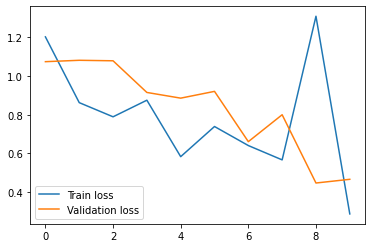

In [77]:
#Evaluate performance
plt.plot(train_losses,label="Train loss")
plt.plot(test_losses, label="Validation loss")
plt.legend()

## Accuracy

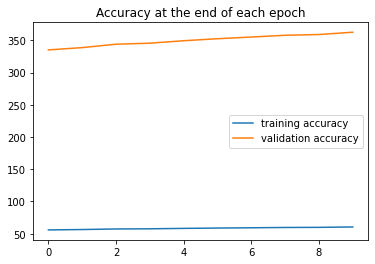

In [78]:
plt.plot([t/600 for t in train_correct], label="training accuracy")
plt.plot([t/100 for t in train_correct], label="validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

## Test on unseen dataset

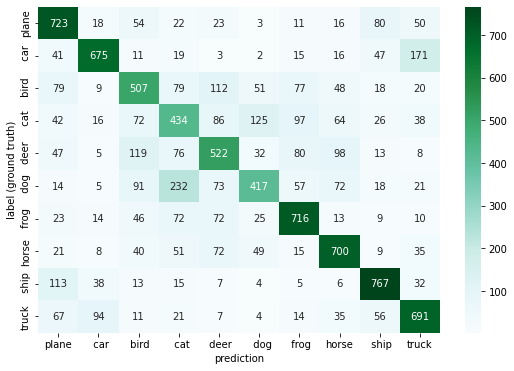

In [85]:
## Create loader

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize=(9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="BuGn")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()
